In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%pylab inline
import os
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator, array_to_img

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
# deal with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import PIL
from PIL import Image
from IPython.display import display
import csv



Populating the interactive namespace from numpy and matplotlib


# Data Prep
- From the initial training images, put 1,000 images into the train directory and 400 into the validation directory

# EDA

In [7]:
number_of_classes = 3

In [8]:
rootdir = '../kaggle - Cervical Cancer Screening/data/train'
train_images_pd = pd.DataFrame()
all_train_images = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        full_path = os.path.join(subdir, file)
        all_train_images.append(full_path)
train_images_pd['image_path']=all_train_images
train_images_pd['type'] = [ x.split('/')[-2] for x in all_train_images] 
all_train_images.remove('../kaggle - Cervical Cancer Screening/data/train/.DS_Store')

In [9]:
train_images_pd .head()

,image_path,type
0,../kaggle - Cervical Cancer Screening/data/tra...,train
1,../kaggle - Cervical Cancer Screening/data/tra...,type_1
2,../kaggle - Cervical Cancer Screening/data/tra...,type_1
3,../kaggle - Cervical Cancer Screening/data/tra...,type_1
4,../kaggle - Cervical Cancer Screening/data/tra...,type_1


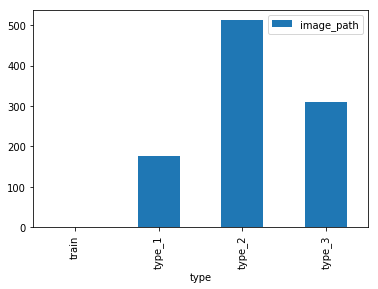

In [40]:
train_images_pd.groupby('type').count().plot(kind='bar')

In [41]:
print('Total of {} images'.format(train_images_pd.shape[0]))

Total of 1001 images


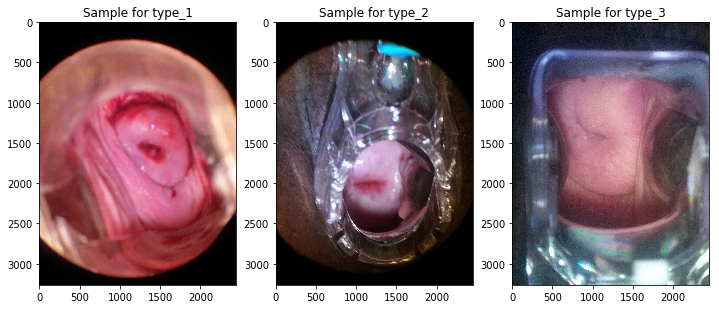

In [64]:
i = 1
fig = plt.figure(figsize=(12,8))
for t in ['type_1','type_2','type_3']:
    ax = fig.add_subplot(1,3,i)
    plt.title('Sample for {}'.format(t))
    i+=1
    f = train_images_pd[train_images_pd.type == t].iloc[0,:]['image_path']
    plt.imshow(plt.imread(f))

# Next, look at image dimensions

In [95]:
[plt.imread(train_images_pd[train_images_pd.type=='type_1'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

[(4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3)]

In [94]:
[plt.imread(train_images_pd[train_images_pd.type=='type_2'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

[(3264, 2448, 3),
 (3264, 2448, 3),
 (4128, 3096, 3),
 (4128, 2322, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (4128, 3096, 3)]

In [96]:
[plt.imread(train_images_pd[train_images_pd.type=='type_3'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

[(4128, 3096, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (3264, 2448, 3),
 (3264, 2448, 3)]

# Set up data generator

In [41]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.vgg16 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [299]:
train_datagen = ImageDataGenerator(
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='data/train',
                                                    target_size=[224, 224],
                                                    batch_size=16,
                                                   classes=['type_1','type_2','type_3'])

Found 1000 images belonging to 3 classes.


In [300]:
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(directory='data/validation/',
                                                              target_size=[224, 224],
                                                              batch_size=16,
                                                             classes=['type_1','type_2','type_3'])

Found 481 images belonging to 3 classes.


### Examine some images after the data augmentation

In [301]:
x_train_augment, y_train_augment = next(train_generator)

In [303]:
x_train_augment.shape

(16, 224, 224, 3)

# Test VGG16 for transfer learning
- First, test out of the box predictions

In [45]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Replace the last layer with only three classes

In [46]:
fc2 = vgg16.get_layer('fc2').output
p = Dense(output_dim=3, activation='softmax', name='logit')(fc2)
model = Model(input=vgg16.input, output=p)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="logit", units=3)`
  
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("lo...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
X_val_sample, y_actual = next(validation_generator)
y_pred = model.predict(X_val_sample)






In [142]:
y_actual[:]

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]], dtype=float32)

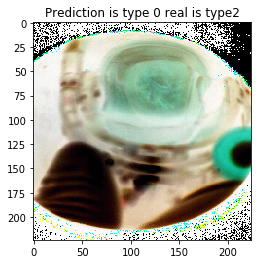

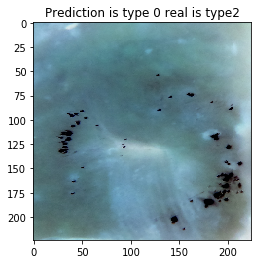

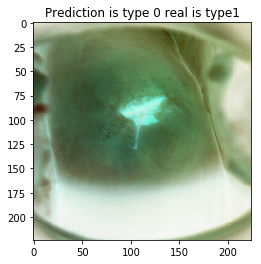

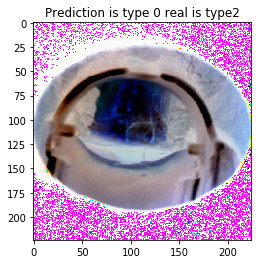

In [147]:
nb_sample = 4
for x, y,z in zip(X_val_sample[:nb_sample], y_pred[:nb_sample],y_actual[:nb_sample,:]):
    plt.figure()
    plt.imshow(x)

    plt.title('Prediction is type {} real is type{}'.format(np.argmax(y),np.argmax(z)))

# Test training just the bottleneck features

In [47]:
model_bottleneck = model

In [48]:
model_bottleneck.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [54]:
for k,v in model_bottleneck.layers_by_depth.items():
    print(k,v[0].trainable,v)
    if k < 3:
        pass
    else:
        v[0].trainable = False

0 True [<keras.layers.core.Dense object at 0x126a7aba8>]
1 True [<keras.layers.core.Dense object at 0x1380b89b0>]
2 True [<keras.layers.core.Dense object at 0x13808fbe0>]
3 False [<keras.layers.core.Flatten object at 0x138072160>]
4 False [<keras.layers.pooling.MaxPooling2D object at 0x138057518>]
5 False [<keras.layers.convolutional.Conv2D object at 0x12f8efd30>]
6 False [<keras.layers.convolutional.Conv2D object at 0x12f8e3cf8>]
7 False [<keras.layers.convolutional.Conv2D object at 0x12f8abc88>]
8 False [<keras.layers.pooling.MaxPooling2D object at 0x12f88de80>]
9 False [<keras.layers.convolutional.Conv2D object at 0x12f854e48>]
10 False [<keras.layers.convolutional.Conv2D object at 0x1274f3f98>]
11 False [<keras.layers.convolutional.Conv2D object at 0x1274ff2b0>]
12 False [<keras.layers.pooling.MaxPooling2D object at 0x1274e53c8>]
13 False [<keras.layers.convolutional.Conv2D object at 0x12737fbe0>]
14 False [<keras.layers.convolutional.Conv2D object at 0x12711f668>]
15 False [<keras

In [51]:
bottleneck_history = [] 
model_bottleneck.load_weights('weights/model_bottleneck.h5')
try:
    loss = model_bottleneck.fit_generator(train_generator,
                        steps_per_epoch=16,
                        epochs=15,
                        validation_data=validation_generator,
                        validation_steps=15);
    bottleneck_history.append(loss)
except:
    pass

# serialize model to YAML
model_yaml_bottleneck = model_bottleneck.to_yaml()
with open("weights/model_bottleneck.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml_bottleneck)
# serialize weights to HDF5
model_bottleneck.save_weights("weights/model_bottleneck.h5")

Epoch 1/5


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

 1/32 [..............................] - ETA: 2541s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 632815616 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12798. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 456523776 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10108. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 2/32 [>.............................] - ETA: 2156s - loss: 9.0664 - acc: 0.4375 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 452067328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10240. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 570097664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11841. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 3/32 [=>............................] - ETA: 1966s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 641466368 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12930. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 5/32 [===>..........................] - ETA: 1664s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482344960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10502. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 490602496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 6/32 [====>.........................] - ETA: 1558s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 431554560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/32 [=====>........................] - ETA: 1464s - loss: 6.9078 - acc: 0.5714

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 438370304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9831. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 8/32 [======>.......................] - ETA: 1383s - loss: 6.9257 - acc: 0.5703

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 617021440 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12757. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 615251968 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12530. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 9/32 [=======>......................] - ETA: 1303s - loss: 7.1636 - acc: 0.5556

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 548274176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6694150584 bytes but only got 0. Skipping tag 19019
  "Skipping tag %s" % (size, len(data), tag))


11/32 [=========>....................] - ETA: 1166s - loss: 7.4180 - acc: 0.5398

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 621150208 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12620. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 597819392 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12264. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

12/32 [==========>...................] - ETA: 1105s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600309760 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12302. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/32 [===========>..................] - ETA: 1044s - loss: 7.5941 - acc: 0.5288

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482738176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521732096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11103. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/32 [============>.................] - ETA: 983s - loss: 7.5554 - acc: 0.5312 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 697368576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13983. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1411602240 bytes but only got 0. Skipping tag 42982
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 446365696 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

15/32 [=============>................] - ETA: 923s - loss: 7.3875 - acc: 0.5417

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600113152 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482148352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10499. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

17/32 [==============>...............] - ETA: 807s - loss: 7.5257 - acc: 0.5331

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 898760704 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16856. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


18/32 [===============>..............] - ETA: 750s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521994240 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11107. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 554041344 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11596. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

19/32 [================>.............] - ETA: 694s - loss: 7.6349 - acc: 0.5263

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 573112320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 701890560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14052. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

20/32 [=================>............] - ETA: 638s - loss: 7.7065 - acc: 0.5219

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 470548480 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10522. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


21/32 [==================>...........] - ETA: 583s - loss: 7.5793 - acc: 0.5298

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600899584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


22/32 [===================>..........] - ETA: 529s - loss: 7.5096 - acc: 0.5341

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 650903552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13274. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


23/32 [====================>.........] - ETA: 475s - loss: 7.4021 - acc: 0.5408

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640024576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12908. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 567083008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11795. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

25/32 [======================>.......] - ETA: 368s - loss: 7.1726 - acc: 0.5550

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 480182272 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10471. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 692191232 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13904. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

26/32 [=======================>......] - ETA: 314s - loss: 7.2454 - acc: 0.5505

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 494862336 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10693. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507576320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

27/32 [========================>.....] - ETA: 261s - loss: 7.2382 - acc: 0.5509

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 520880128 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11090. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21488365096 bytes but only got 0. Skipping tag 40486
  "Skipping tag %s" % (size, len(data), tag))


29/32 [==========================>...] - ETA: 156s - loss: 7.3643 - acc: 0.5431

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 537722880 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11347. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425066496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

30/32 [===========================>..] - ETA: 104s - loss: 7.3875 - acc: 0.5417

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 631046144 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12771. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


31/32 [============================>.] - ETA: 51s - loss: 7.4741 - acc: 0.5363 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 512098304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10956. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5613949592 bytes but only got 0. Skipping tag 19083
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 628752384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

32/32 [==============================] - 2205s - loss: 7.6183 - acc: 0.5273 - val_loss: 7.0699 - val_acc: 0.5614
Epoch 2/5


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 476315648 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10410. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 488898560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10602. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 1/32 [..............................] - ETA: 1563s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507248640 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10884. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 2/32 [>.............................] - ETA: 1490s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 644612096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12978. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587792384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 3/32 [=>............................] - ETA: 1436s - loss: 8.7306 - acc: 0.4583 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 487981056 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10588. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 4/32 [==>...........................] - ETA: 1401s - loss: 8.8146 - acc: 0.4531

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587857920 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12112. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 451346432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10029. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 5/32 [===>..........................] - ETA: 1440s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 665649152 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 6/32 [====>.........................] - ETA: 1384s - loss: 8.5627 - acc: 0.4688

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 539820032 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11379. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/32 [=====>........................] - ETA: 1321s - loss: 8.6347 - acc: 0.4643

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587464704 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12106. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1839658997 bytes but only got 0. Skipping tag 28034
  "Skipping tag %s" % (size, len(data), tag))


10/32 [========>.....................] - ETA: 1230s - loss: 8.3613 - acc: 0.4813

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 798556160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 15327. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 765788160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14827. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

11/32 [=========>....................] - ETA: 1196s - loss: 8.7917 - acc: 0.4545

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587005952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


12/32 [==========>...................] - ETA: 1171s - loss: 8.4788 - acc: 0.4740

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 559677440 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11682. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/32 [===========>..................] - ETA: 1130s - loss: 8.4465 - acc: 0.4760

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 707657728 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13940. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640811008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12920. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

15/32 [=============>................] - ETA: 1027s - loss: 8.3277 - acc: 0.4833

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 479068160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/32 [==============>...............] - ETA: 977s - loss: 8.1850 - acc: 0.4922 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 775159808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14970. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


17/32 [==============>...............] - ETA: 923s - loss: 8.1776 - acc: 0.4926

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 545652736 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11468. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


18/32 [===============>..............] - ETA: 868s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 727973888 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14450. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 661848064 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13441. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

19/32 [================>.............] - ETA: 812s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 624295936 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12668. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531496960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

32/32 [==============================] - 2766s - loss: 8.0876 - acc: 0.4982 - val_loss: 7.1023 - val_acc: 0.5594

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 439287808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 9847. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


22/32 [===================>..........] - ETA: 727s - loss: 8.1048 - acc: 0.4972 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 878444544 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 16746. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


23/32 [====================>.........] - ETA: 656s - loss: 8.2342 - acc: 0.4891

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 846528512 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16059. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26073062320 bytes but only got 0. Skipping tag 50256
  "Skipping tag %s" % (size, len(data), tag))


32/32 [==============================] - 3114s - loss: 8.1535 - acc: 0.4941 - val_loss: 6.7780 - val_acc: 0.5795
Epoch 4/5
32/32 [==============================] - 2858s - loss: 7.8357 - acc: 0.5139 - val_loss: 7.0050 - val_acc: 0.5654

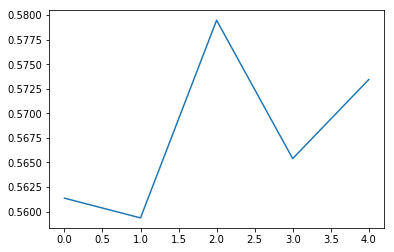

In [59]:
plt.plot(loss.history['val_acc'])

# Test the bottleneck features

In [64]:
rootdir = '../kaggle - Cervical Cancer Screening/data/test'
test_images_pd = pd.DataFrame()
all_test_images = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        full_path = os.path.join(subdir, file)
        all_test_images.append(full_path)

In [116]:
all_test_images[i].split('/')[-1]

'0.jpg'

In [151]:
row = []
with open('bottleneck_predictions.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['image_name','Type_1','Type_2','Type_3'])
    for image in all_test_images:
        name = image.split('/')[-1]

        img = Image.open(image)
        img = img.resize((224,224), PIL.Image.ANTIALIAS)
        img = np.array(img).reshape(1,224,224,3)
        prediction = model_bottleneck.predict(img)
        print(prediction)
        spamwriter.writerow([name,prediction[0][0],prediction[0][1],prediction[0][2]])

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 611057664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12666. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 680591360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 559480832 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11879. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204865536 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205389824 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 558563328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11665. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 594411520 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12212. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 750845952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14799. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 497156096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10928. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 716505088 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14275. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 499122176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10758. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 565903360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11777. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 668860416 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13548. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 566886400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11792. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 654901248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13135. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 513671168 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10980. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 671154176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13583. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 542310400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11417. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 896663552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16824. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 457703424 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10126. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 467402752 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10474. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 471859200 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10342. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 627507200 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12917. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25880427512 bytes but only got 0. Skipping tag 20602
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178651468 bytes but only got 0. Skipping tag 20656
  "Skipping tag %s" % (size, len(dat

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 454950912 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10284. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 715718656 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14263. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 499187712 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10759. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 527171584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11186. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 518914048 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11060. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 653459456 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13113. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 541589504 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11406. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 510197760 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10927. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 760020992 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14739. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 372937384 bytes but only got 0. Skipping tag 39948
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 445775872 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9944. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 592576512 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12184. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 458293248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10135. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 615579648 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12535. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 550502400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11542. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 411828224 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9426. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 572391424 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11876. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 670171136 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13568. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 599064576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12283. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 539426816 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11373. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 602996736 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12343. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 421462016 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9573. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531562496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11253. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 622264320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12637. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204996608 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205520896 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 670892032 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 13381. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 605028352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12374. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 452460544 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10046. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 647168000 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13017. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 518586368 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11055. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26527738112 bytes but only got 0. Skipping tag 19153
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 537329664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11341. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 532021248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11260. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 592379904 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12181. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


# Try training the last CNN layer and the bottleneck layer


In [156]:
model_bottleneck_last_cnn = model_bottleneck

In [157]:
model_bottleneck_last_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [166]:
for k,v in model_bottleneck_last_cnn.layers_by_depth.items():
    
    if k < 8:
        v[0].trainable = True
    else:
        v[0].trainable = False
    print(k,v[0].trainable,v)

0 True [<keras.layers.core.Dense object at 0x126a7aba8>]
1 True [<keras.layers.core.Dense object at 0x1380b89b0>]
2 True [<keras.layers.core.Dense object at 0x13808fbe0>]
3 True [<keras.layers.core.Flatten object at 0x138072160>]
4 True [<keras.layers.pooling.MaxPooling2D object at 0x138057518>]
5 True [<keras.layers.convolutional.Conv2D object at 0x12f8efd30>]
6 True [<keras.layers.convolutional.Conv2D object at 0x12f8e3cf8>]
7 True [<keras.layers.convolutional.Conv2D object at 0x12f8abc88>]
8 False [<keras.layers.pooling.MaxPooling2D object at 0x12f88de80>]
9 False [<keras.layers.convolutional.Conv2D object at 0x12f854e48>]
10 False [<keras.layers.convolutional.Conv2D object at 0x1274f3f98>]
11 False [<keras.layers.convolutional.Conv2D object at 0x1274ff2b0>]
12 False [<keras.layers.pooling.MaxPooling2D object at 0x1274e53c8>]
13 False [<keras.layers.convolutional.Conv2D object at 0x12737fbe0>]
14 False [<keras.layers.convolutional.Conv2D object at 0x12711f668>]
15 False [<keras.laye

In [169]:
model_bottleneck_last_cnn.load_weights('weights/model_bottleneck.h5')

loss = model_bottleneck_last_cnn.fit_generator(train_generator,
                        steps_per_epoch=16,
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=16);

# serialize model to YAML
model_yaml_bottleneck = model_bottleneck.to_yaml()
with open("weights/model_bottleneck_last_cnn.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml_bottleneck)
# serialize weights to HDF5
model_bottleneck.save_weights("weights/model_bottleneck_last_cnn.h5")

Epoch 1/30


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

 1/16 [>.............................] - ETA: 1147s - loss: 11.0812 - acc: 0.3125

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 196608 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 479068160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521994240 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Us

 2/16 [==>...........................] - ETA: 966s - loss: 9.0664 - acc: 0.4375  

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 548274176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6694150584 bytes but only got 0. Skipping tag 19019
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 759824384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

 3/16 [====>.........................] - ETA: 861s - loss: 8.7306 - acc: 0.4583

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 853671936 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 16368. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 488898560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10602. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 4/16 [======>.......................] - ETA: 768s - loss: 8.3109 - acc: 0.4844

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 621150208 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12620. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 6/16 [==========>...................] - ETA: 606s - loss: 8.2269 - acc: 0.4896

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 632815616 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12798. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 537722880 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11347. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 8/16 [==============>...............] - ETA: 471s - loss: 8.6887 - acc: 0.4609

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 554041344 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11596. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1351410386 bytes but only got 0. Skipping tag 50513
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 22727707048 bytes but only got 0. Skipping tag 59491
  "Skipping tag %s" % (size, len(da

11/16 [===================>..........] - ETA: 287s - loss: 7.9675 - acc: 0.5057

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204996608 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205520896 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 439287808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 9847. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/

12/16 [=====================>........] - ETA: 229s - loss: 7.7233 - acc: 0.5208

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482148352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10499. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/16 [=======================>......] - ETA: 171s - loss: 7.8266 - acc: 0.5144

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 438370304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9831. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 615251968 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12530. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

14/16 [=========================>....] - ETA: 113s - loss: 7.9151 - acc: 0.5089

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587005952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


15/16 [===========================>..] - ETA: 56s - loss: 7.8576 - acc: 0.5125 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 508428288 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10900. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 589561856 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12338. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

16/16 [==============================] - 1186s - loss: 7.9961 - acc: 0.5039 - val_loss: 6.8218 - val_acc: 0.5768
Epoch 2/30


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 609681408 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12645. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425066496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

 1/16 [>.............................] - ETA: 792s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600899584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 476315648 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10410. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 4/16 [======>.......................] - ETA: 634s - loss: 8.5627 - acc: 0.4688

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 798556160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 15327. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 6/16 [==========>...................] - ETA: 528s - loss: 8.3948 - acc: 0.4792

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 944046080 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 17547. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/16 [============>.................] - ETA: 476s - loss: 8.4908 - acc: 0.4732

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 727973888 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14450. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 9/16 [===============>..............] - ETA: 371s - loss: 8.2829 - acc: 0.4861

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507248640 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10884. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


10/16 [=================>............] - ETA: 318s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 581763072 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12019. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/16 [=======================>......] - ETA: 155s - loss: 8.6015 - acc: 0.4663

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 597819392 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12264. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 765788160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14827. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/16 [=========================>....] - ETA: 103s - loss: 8.7066 - acc: 0.4598

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640024576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12908. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


15/16 [===========================>..] - ETA: 52s - loss: 8.5963 - acc: 0.4667 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 832897024 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 16051. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 481689600 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10492. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

16/16 [==============================] - 1152s - loss: 8.4261 - acc: 0.4772 - val_loss: 6.6739 - val_acc: 0.5859
Epoch 3/30
 1/16 [>.............................] - ETA: 838s - loss: 7.0517 - acc: 0.5625

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 846528512 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16059. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26073062320 bytes but only got 0. Skipping tag 50256
  "Skipping tag %s" % (size, len(data), tag))


 2/16 [==>...........................] - ETA: 767s - loss: 9.5701 - acc: 0.4062

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521732096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11103. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 558104576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11658. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 5/16 [========>.....................] - ETA: 604s - loss: 9.2679 - acc: 0.4250

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 446365696 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9953. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33917591880 bytes but only got 0. Skipping tag 37986
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 560201728 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

 6/16 [==========>...................] - ETA: 551s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 545652736 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11468. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 650903552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13274. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 7/16 [============>.................] - ETA: 493s - loss: 8.3469 - acc: 0.4821

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 461438976 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10383. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 8/16 [==============>...............] - ETA: 437s - loss: 8.4368 - acc: 0.4766

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 697106432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13979. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 9/16 [===============>..............] - ETA: 382s - loss: 8.3948 - acc: 0.4792

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 692191232 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13904. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20791909992 bytes but only got 0. Skipping tag 39940
  "Skipping tag %s" % (size, len(data), tag))


11/16 [===================>..........] - ETA: 271s - loss: 8.6085 - acc: 0.4659

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 470548480 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10522. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 456589312 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10111. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

13/16 [=======================>......] - ETA: 161s - loss: 8.2915 - acc: 0.4856

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 452067328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10240. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 465633280 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10247. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/16 [=========================>....] - ETA: 107s - loss: 8.4188 - acc: 0.4777

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 539820032 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11379. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 661848064 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13441. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

15/16 [===========================>..] - ETA: 53s - loss: 8.4620 - acc: 0.4750 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 641335296 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12928. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 1141s - loss: 8.3109 - acc: 0.4844 - val_loss: 6.9555 - val_acc: 0.5685
Epoch 4/30
 1/16 [>.............................] - ETA: 797s - loss: 6.0443 - acc: 0.6250

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507576320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482344960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10502. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 4/16 [======>.......................] - ETA: 635s - loss: 6.7998 - acc: 0.5781

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640811008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12920. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 462749696 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10205. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 8/16 [==============>...............] - ETA: 419s - loss: 7.4294 - acc: 0.5391

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 525139968 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11355. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


10/16 [=================>............] - ETA: 311s - loss: 7.1524 - acc: 0.5563

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 480182272 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10471. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


12/16 [=====================>........] - ETA: 207s - loss: 7.2196 - acc: 0.5521

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 682098688 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13750. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5857942016 bytes but only got 0. Skipping tag 28311
  "Skipping tag %s" % (size, len(data), tag))


14/16 [=========================>....] - ETA: 103s - loss: 7.4114 - acc: 0.5402

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 490602496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 1094s - loss: 7.4294 - acc: 0.5391 - val_loss: 6.9555 - val_acc: 0.5685
Epoch 5/30
 1/16 [>.............................] - ETA: 776s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 567083008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11795. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 3/16 [====>.........................] - ETA: 664s - loss: 9.4022 - acc: 0.4167 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 451346432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10029. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 13163983368 bytes but only got 0. Skipping tag 14341
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2720631504 bytes but only got 0. Skipping tag 42848
  "Skipping tag %s" % (size, len(da

 6/16 [==========>...................] - ETA: 508s - loss: 8.5627 - acc: 0.4688

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 460455936 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10168. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7974292302 bytes but only got 0. Skipping tag 53378
  "Skipping tag %s" % (size, len(data), tag))


 8/16 [==============>...............] - ETA: 404s - loss: 8.1850 - acc: 0.4922

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 571146240 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11857. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


10/16 [=================>............] - ETA: 303s - loss: 7.9583 - acc: 0.5062

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 494862336 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10693. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


11/16 [===================>..........] - ETA: 252s - loss: 7.9675 - acc: 0.5057

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587857920 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12112. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 442695680 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9897. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

12/16 [=====================>........] - ETA: 202s - loss: 7.8072 - acc: 0.5156

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 512098304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10956. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5613949592 bytes but only got 0. Skipping tag 19083
  "Skipping tag %s" % (size, len(data), tag))


13/16 [=======================>......] - ETA: 151s - loss: 7.8266 - acc: 0.5144

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 520880128 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11090. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21488365096 bytes but only got 0. Skipping tag 40486
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531496960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), 

16/16 [==============================] - 1096s - loss: 7.6813 - acc: 0.5234 - val_loss: 7.1146 - val_acc: 0.5586
Epoch 6/30


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482738176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 1079s - loss: 8.0036 - acc: 0.5034 - val_loss: 6.8886 - val_acc: 0.5726

### test predictions and see if they've changed

In [172]:
row = []
with open('bottleneck_last_cnn_predictions.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['image_name','Type_1','Type_2','Type_3'])
    for image in all_test_images:
        name = image.split('/')[-1]

        img = Image.open(image)
        img = img.resize((224,224), PIL.Image.ANTIALIAS)
        img = np.array(img).reshape(1,224,224,3)
        prediction = model_bottleneck_last_cnn.predict(img)
        print(prediction)
        spamwriter.writerow([name,prediction[0][0],prediction[0][1],prediction[0][2]])

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 611057664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12666. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 680591360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 559480832 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11879. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204865536 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205389824 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 558563328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11665. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 594411520 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12212. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 750845952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14799. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 497156096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10928. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 716505088 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14275. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 499122176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10758. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 565903360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11777. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 668860416 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13548. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 566886400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11792. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 654901248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13135. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 513671168 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10980. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 671154176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13583. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 542310400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11417. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 896663552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16824. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 457703424 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10126. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


KeyboardInterrupt: 

### Even with training the last layer, still just predicting class 2

### Visualize the weights to see how many layers we should finetune
- Last convolution block

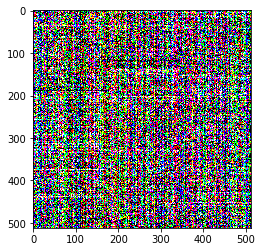

In [217]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block5_conv3').get_weights()[0][0].reshape(512,512,3))

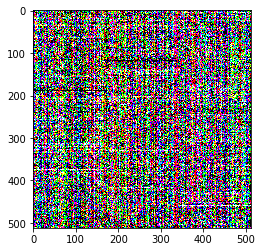

In [218]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block5_conv3').get_weights()[0][1].reshape(512,512,3))

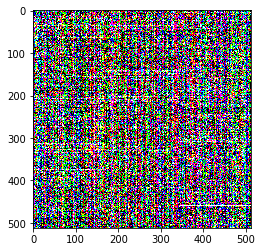

In [219]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block5_conv3').get_weights()[0][2].reshape(512,512,3))

- Last layer of 4th block

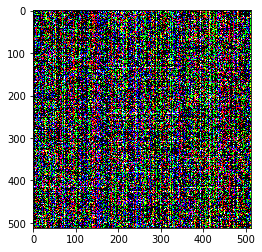

In [222]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block4_conv3').get_weights()[0][1].reshape(512,512,3))

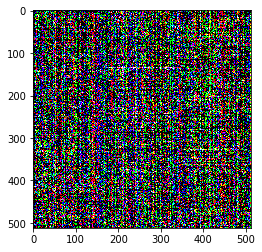

In [223]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block4_conv3').get_weights()[0][2].reshape(512,512,3))

# Test the inception framework

In [276]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

In [277]:
xception_model = Xception(weights='imagenet')

In [278]:
xception_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

### Change the last layer for three classes

In [309]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_xception_finetune = model

0 input_11
1 conv2d_625
2 batch_normalization_624
3 activation_620
4 conv2d_626
5 batch_normalization_625
6 activation_621
7 conv2d_627
8 batch_normalization_626
9 activation_622
10 max_pooling2d_28
11 conv2d_628
12 batch_normalization_627
13 activation_623
14 conv2d_629
15 batch_normalization_628
16 activation_624
17 max_pooling2d_29
18 conv2d_633
19 batch_normalization_632
20 activation_628
21 conv2d_631
22 conv2d_634
23 batch_normalization_630
24 batch_normalization_633
25 activation_626
26 activation_629
27 average_pooling2d_60
28 conv2d_630
29 conv2d_632
30 conv2d_635
31 conv2d_636
32 batch_normalization_629
33 batch_normalization_631
34 batch_normalization_634
35 batch_normalization_635
36 activation_625
37 activation_627
38 activation_630
39 activation_631
40 mixed0
41 conv2d_640
42 batch_normalization_639
43 activation_635
44 conv2d_638
45 conv2d_641
46 batch_normalization_637
47 batch_normalization_640
48 activation_633
49 activation_636
50 average_pooling2d_61
51 conv2d_637
5

In [295]:
model_xception_finetune.compile(loss='binary_crossentropy', metrics =['accuracy'],optimizer='adam')

### Data generator with new target size for inception

In [297]:
train_datagen_xception = ImageDataGenerator(
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator_xception = train_datagen.flow_from_directory(directory='data/train',
                                                    target_size=[229, 229],
                                                    batch_size=16,
                                                   classes=['type_1','type_2','type_3'])
validation_datagen_xception = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_generator_xception = validation_datagen.flow_from_directory(directory='data/validation/',
                                                              target_size=[229, 229],
                                                              batch_size=16,
                                                             classes=['type_1','type_2','type_3'])

Found 1000 images belonging to 3 classes.
Found 481 images belonging to 3 classes.


##### Visualize some images

In [239]:
x,y = next(train_generator_inception)

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

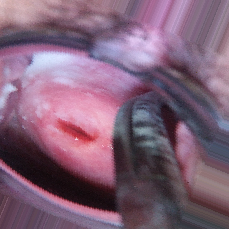

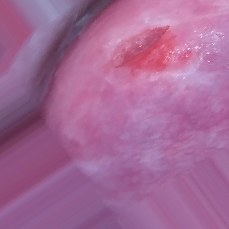

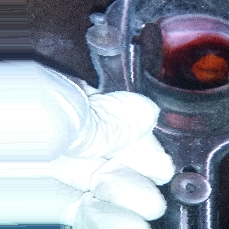

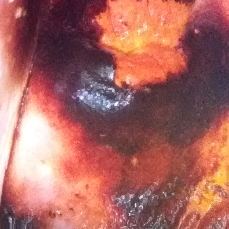

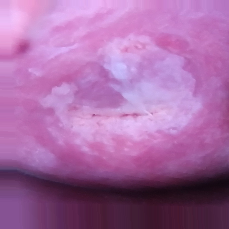

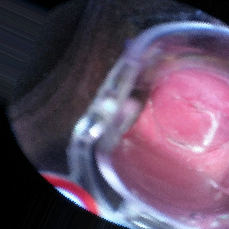

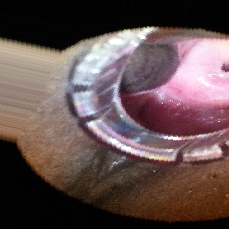

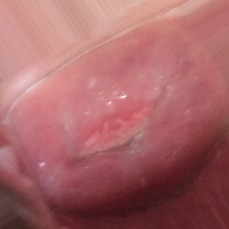

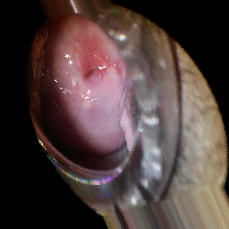

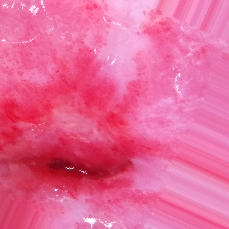

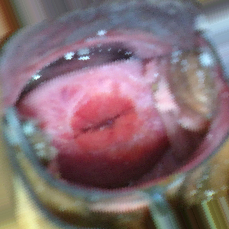

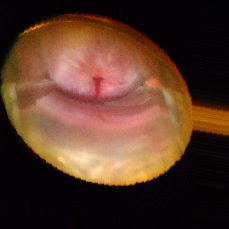

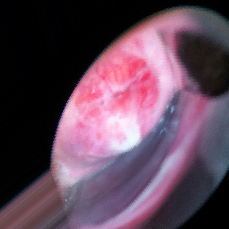

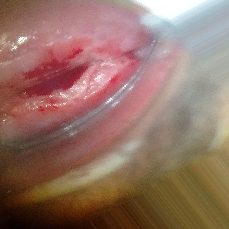

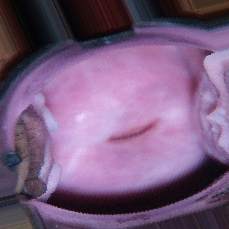

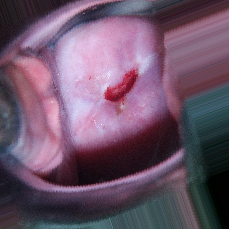

In [249]:
for i in x:
    display(array_to_img( i))

In [308]:
# train the model on the new data for a few epochs
model_xception_finetune.fit_generator(train_generator_xception,
                        steps_per_epoch=16,
                        epochs=1,
                        validation_data=validation_generator_xception,
                        validation_steps=15);

Epoch 1/1


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

 2/16 [==>...........................] - ETA: 469s - loss: 1.0429

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 661848064 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13441. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 3/16 [====>.........................] - ETA: 367s - loss: 1.0467

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 765788160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14827. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9817664632 bytes but only got 0. Skipping tag 52436
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482148352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

 4/16 [======>.......................] - ETA: 301s - loss: 1.0268

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 451346432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10029. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 13163983368 bytes but only got 0. Skipping tag 14341
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2720631504 bytes but only got 0. Skipping tag 42848
  "Skipping tag %s" % (size, len(da

 5/16 [========>.....................] - ETA: 270s - loss: 1.0487

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507576320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 431554560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

 6/16 [==========>...................] - ETA: 238s - loss: 1.0531

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640024576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12908. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 697368576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13983. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 7/16 [============>.................] - ETA: 216s - loss: 1.0526

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425066496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 8/16 [==============>...............] - ETA: 213s - loss: 1.0549

KeyboardInterrupt: 